In [2]:
# Goal of the notebook: generate subset of G4423 MERFISH data including around 1700 cells for algorithm development
# Gensim HDP was run on original single cells and the cells with 15 nearest neighbors
# The script was written by Chi-Yun Wu < chiyun.wu@gladstone.ucsf.edu>

In [ ]:
# import Genism package
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import HdpModel
from gensim import corpora
from gensim.utils import simple_preprocess
import pandas as pd
import os
from os import path
import string
import numpy as np
import pandas as pd
import anndata as ad

import h5py    
import numpy as np    
import scanpy as sc
from scanpy import read_h5ad
import scipy as scipy

In [3]:
os.chdir("/wynton/home/engelhardt/chwu/Projects/HubID/Gensim_revised/")

# Import data

In [33]:
# # resave the original file
# mtx=pd.read_csv('./Data/G4423_15_neighbor_sums.csv')
# colnames=mtx.columns.tolist()
# with open("./Data/G4423_15_neighbor_sums_colnames.csv", "w") as file1:
#     jcol=",".join(colnames)+'\n'
#     # Writing data to a file
#     file1.write(jcol)

# mtx2=scipy.sparse.csr_matrix(np.array(mtx))
# scipy.sparse.save_npz('./Data/G4423_15_neighbor_sums.npz', mtx2)

###### cell_by_gene
# mtx=pd.read_csv('/wynton/group/gladstone/users/cywu/Broad_MERFISH_Datasets/G4423_20220427/cellpose_cell_by_gene.csv')
# mtx2=scipy.sparse.csr_matrix(np.array(mtx))
# scipy.sparse.save_npz('../neighbor_smooth/Data/G4423_cellpose_cell_by_gene.npz', mtx2)

# for 15 neighbors

In [36]:
## 15neighbors
# mtx=scipy.sparse.load_npz("../neighbor_smooth/Data/G4423_15_neighbor_sums.npz")
with open("../neighbor_smooth/Data/G4423_15_neighbor_sums_colnames.csv", "r+") as file1:
    # Reading form a file
    colnames=file1.read()
    
colnames=colnames.strip("\n").split(",")

mtx=scipy.sparse.load_npz("../neighbor_smooth/Data/G4423_cellpose_cell_by_gene.npz")

In [37]:
mtx

<546289x551 sparse matrix of type '<class 'numpy.float64'>'
	with 17451108 stored elements in Compressed Sparse Row format>

In [38]:
mtx=pd.DataFrame(mtx.todense())
mtx.columns=colnames
mtx=mtx.iloc[:,1:]
mtx

,COL3A1,HLA-E,VIM,JUN,STMN1,ASCL2,TIMP1,HLA-DRB1,DNAJB1,PSMB8,...,Blank-27,Blank-68,UBE2C,Blank-62,SPP1,Blank-17,Blank-40,COL10A1,Blank-9,Blank-59
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546284,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
546285,1.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
546286,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
546287,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# import spatial info
#meta=pd.read_csv('/wynton/group/gladstone/users/cywu/Broad_MERFISH_Datasets/G4423_20220427/cellpose_cell_metadata.csv')
meta=pd.read_csv('/gladstone/engelhardt/pelka-collaboration/Broad_MERFISH_Datasets/G4423_20220427/cellpose_cell_metadata.csv')
coordinates0=np.array(meta[['center_x', 'center_y']])
coordinates=coordinates0
# flip y
coordinates[:,1]=max(coordinates0[:,1])-coordinates0[:,1]


In [40]:
coordinates

array([[11034.14202732,  8681.29058697],
       [11038.9741895 ,  8681.99590744],
       [11058.40741954,  8666.81880036],
       ...,
       [11842.5858035 ,  2830.17602741],
       [11746.48760914,  2829.75679688],
       [11733.95617749,  2828.74821881]])

# create Anndata object

In [41]:
adata = sc.AnnData(mtx, 
    mtx.index.to_frame(), 
    mtx.columns.to_frame())
adata.obsm['spatial']=coordinates

/scratch/chwu/ipykernel_26798/500333676.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(mtx,
/wynton/home/engelhardt/chwu/miniconda3/envs/NSF38/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [42]:
#adata_sub=adata#sc.pp.subsample(adata, fraction=0.01, copy=True, random_state=0)
adata_sub=adata.copy()
adata_sub=adata_sub[((adata_sub.obsm['spatial'][:,0]>6000)& (adata_sub.obsm['spatial'][:,0]<6500)) & ((adata_sub.obsm['spatial'][:,1]<max((adata_sub.obsm['spatial'][:,1])-500)) & (adata_sub.obsm['spatial'][:,1]>(max(adata_sub.obsm['spatial'][:,1])-1000))) ]                                   
                                            
                                            

print(adata_sub.shape)
sc.pp.filter_cells(adata_sub, min_genes=1)
print(adata_sub.shape)
print(adata_sub.obsm['spatial'])

(1700, 550)
(1684, 550)
[[ 6326.55646658 11424.35388773]
 [ 6349.99031207 11424.45919143]
 [ 6417.03584561 11423.23430788]
 ...
 [ 6172.85290034 10927.42943493]
 [ 6251.77447624 10929.34336705]
 [ 6271.01308512 10925.62546761]]


/wynton/home/engelhardt/chwu/miniconda3/envs/NSF38/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


# Topic models

In [43]:
dat=adata_sub.X
print(dat.shape)
gene_names=adata_sub.var.iloc[:,0].tolist()
print(gene_names[0:5])

(1684, 550)
['COL3A1', 'HLA-E', 'VIM', 'JUN', 'STMN1']


In [44]:
# generate BoW from the simulation data
# doc_lists=[]
# for ii in range(dat.shape[0]):
#     rr=dat[ii,:]
#     rr=rr.astype(int)
#     ind=0
#     doc=''
#     for jj in rr:
#         if jj>0:
#             tmp=str(gene_names[ind])+" "
#             doc=doc+tmp*int(jj)
#         ind+=1
#     doc_lists.append(doc)


doc_tokenized=[]
for ii in range(dat.shape[0]):
    rr=dat[ii,:]
    rr=rr.astype(int)
    ind=0
    doc=[]
    for jj in rr:
        if jj>0:
            for tt in range(jj):
                doc.append(str(gene_names[ind]))
        ind+=1
    doc_tokenized.append(doc)

In [45]:
import pickle
# Save the model
with open('/wynton/home/engelhardt/chwu/Projects/HubID/Gensim_revised/objects/G4423_doc_tokenized_sub500.pkl', 'wb') as ff:
    pickle.dump(doc_tokenized, ff)
    
#with open('/wynton/home/engelhardt/chwu/Projects/HubID/neighbor_smooth/Data/G4423_15_neighbor_doc_tokenized.pkl', 'rb') as f2:
#    doc_tokenized = pickle.load(f2)


In [ ]:
# print(len(doc_lists))
# print(len(doc_tokenized))
# print(doc_lists[0:5])
# print("------------------")
# print(doc_tokenized[0:5])

In [46]:
dictionary = corpora.Dictionary()
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]

In [47]:
import pickle
# Save the model
with open('/wynton/home/engelhardt/chwu/Projects/HubID/Gensim_revised/objects/G4423_dictionary_sub500.pkl', 'wb') as ff:
    pickle.dump(dictionary, ff)
    
with open('/wynton/home/engelhardt/chwu/Projects/HubID/Gensim_revised/objects/G4423_BoW_corpus_sub500.pkl', 'wb') as f2:
    pickle.dump(BoW_corpus, f2)
    
# with open('/wynton/home/engelhardt/chwu/Projects/HubID/neighbor_smooth/Data/G4423_15_neighbor_dictionary.pkl', 'rb') as ff:
#     dictionary = pickle.load(ff)

# with open('/wynton/home/engelhardt/chwu/Projects/HubID/neighbor_smooth/Data/G4423_15_neighbor_BoW_corpus.pkl', 'rb') as f2:
#     BoW_corpus = pickle.load(f2)


In [48]:
# train HDP model
K=100
T=100
hdp = HdpModel(BoW_corpus, dictionary, gamma=1, alpha=1, T=T,K=K, kappa=1, random_state=0)

result_dist=hdp[BoW_corpus]

#topic_info=hdp.print_topics()
topic_info=hdp.get_topics()
topic_info.shape

Dictionary<548 unique tokens: ['AIF1', 'ANXA1', 'BHLHE40', 'BMP2', 'Blank-39']...>


(100, 548)

In [49]:
# save model
hdp.save('/wynton/home/engelhardt/chwu/Projects/HubID/Gensim_revised/models/hdp_G4423_sub500.model')

# read model
#hdp= HdpModel.load('/wynton/home/engelhardt/chwu/Projects/HubID/neighbor_smooth/Models/hdp_all.model')


# save result_dist

In [50]:
#topic_info=hdp.print_topics()
topic_info=hdp.get_topics()
topic_info.shape
topic_info

array([[2.03430357e-04, 3.66230577e-03, 5.22495685e-03, ...,
        8.13832081e-04, 1.94503796e-04, 8.84348558e-05],
       [4.77681484e-03, 1.79269991e-03, 4.33073348e-03, ...,
        2.76416730e-03, 9.58165564e-05, 6.36521555e-04],
       [4.55426568e-03, 5.72668327e-03, 3.80959005e-03, ...,
        1.66829577e-04, 7.49505605e-04, 1.41918525e-03],
       ...,
       [2.52679790e-04, 9.38524015e-04, 7.64843747e-04, ...,
        1.41885751e-03, 9.26904619e-04, 3.39436979e-04],
       [6.82300653e-05, 1.59645864e-03, 3.14597059e-03, ...,
        4.63916794e-03, 4.34023702e-04, 8.09687625e-04],
       [1.70077294e-03, 2.67350317e-03, 5.96086051e-03, ...,
        1.67325794e-03, 5.65610170e-04, 1.65979516e-05]])

In [ ]:
# # pre
# prop=pd.DataFrame([])
# for ii in range(dat.shape[0]):
#     dic={}
#     for jj in range(len(topic_info)):
#         result=dict(result_dist[ii])
#         if jj in result.keys():
#             dic['K'+str(jj)]=[result[jj]]
#         else:
#             dic['K'+str(jj)]=[0]
#     rr=pd.DataFrame(dic)
#     prop=prop.append(rr)
    
    
# #df = pd.DataFrame({
# #    'col_1': [0, 1, 2, 3],
# #    'col_2': [4, 5, 6, 7]
# #})
# prop=np.array(prop)

In [51]:
## see if prop table can be generate faster
prop = np.empty((dat.shape[0],K), float)#pd.DataFrame([])
for ii in range(dat.shape[0]):
    #dic={}
    rr=np.zeros(K)
    result=np.array(result_dist[ii])
    rr[result[:,0].astype(int)]=result[:,1]
    rr=np.reshape(rr,(1,K)) 
    prop[ii,:]=rr
    #prop=np.append(prop, rr, axis=0)
    print(ii)
    
#df = pd.DataFrame({
#    'col_1': [0, 1, 2, 3],
#    'col_2': [4, 5, 6, 7]
#})
#prop=np.array(prop)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [52]:
#result_dist[1341]
#doc_tokenized[1341]
#dat[1341]
#print(prop_test)
#print("---------------")
print(prop)
print(prop.shape)

[[7.61084837e-01 2.17630277e-01 5.38117789e-04 ... 1.49618346e-04
  2.07123047e-04 1.13419725e-04]
 [9.91225919e-01 3.01456123e-04 2.14202227e-04 ... 5.95568173e-05
  8.24470382e-05 4.51476573e-05]
 [9.94093266e-01 2.02941050e-04 1.44201499e-04 ... 4.00938051e-05
  5.55035617e-05 3.03935210e-05]
 ...
 [3.87877675e-01 2.52438867e-04 1.79372596e-04 ... 4.98727820e-05
  6.90410158e-05 3.78065748e-05]
 [9.87787428e-01 4.19594333e-04 2.98146343e-04 ... 8.28966511e-05
  1.14757364e-04 6.28406582e-05]
 [9.94620653e-01 1.84821313e-04 1.31326365e-04 ... 3.65140011e-05
  5.05478865e-05 2.76798137e-05]]
(1684, 100)


In [53]:
# save prop
np.save("/wynton/home/engelhardt/chwu/Projects/HubID/Gensim_revised/tables/prop_G4423_sub500_seed0.npy", prop)
#prop=np.load("/wynton/home/engelhardt/chwu/Projects/HubID/neighbor_smooth/Tables//prop_subregion_seed0.npy")

In [54]:
# getting the main topics
clusters=[]
for ii in range(prop.shape[0]):
    clusters.append(prop[ii,:].argmax())

In [55]:
clusters[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Visualization and other clustering

In [23]:
# # leiden clustering
# sc.pp.neighbors(adata_sub, n_neighbors=15, use_rep='X')
# sc.tl.leiden(adata_sub)

/wynton/home/engelhardt/chwu/miniconda3/envs/NSF38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-31 21:43:11.922257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# #kmeans with k=5
# from sklearn.cluster import KMeans
# from sklearn.metrics import adjusted_rand_score
# X=adata_sub.X
# kmeans = KMeans(n_clusters=7, random_state=0).fit(X) 
# adata_sub.obs['kmeans7'] = kmeans.labels_.astype(str)

In [56]:
adata_sub.obs['HDP_cluster']=clusters
adata_sub.obs=adata_sub.obs.astype({'HDP_cluster':'category'})
adata_sub.obs.dtypes

0                 int64
n_genes           int64
HDP_cluster    category
dtype: object

In [57]:
# hdp to anndata
adata_sub.obsm['HDP']=prop
#adata_sub.obsm['HDP']=np.array(meta[['center_x', 'center_y']])

In [58]:
# save to adddata object
#import hdf5plugin
adata_sub.obs.rename(columns={0: "index"}, inplace=True)
adata_sub.var.rename(columns={0: "gene"}, inplace=True)
adata_sub.write_h5ad(
    "/wynton/home/engelhardt/chwu/Projects/HubID/Gensim_revised/objects/adata_G4423_sub500.h5ad",
    compression="gzip"
)

In [ ]:
#tmp=sc.read_h5ad("/wynton/home/engelhardt/chwu/Projects/HubID/neighbor_smooth/Data/G4423_adata_HDP.h5ad")

Backing file manager: no file is set.

In [61]:
# sc.pl.spatial(adata_sub, spot_size=10, color=['leiden','HDP_cluster'], show=True, 
#                      save="_spatial_clustering_G4423_sub500_p30.pdf")
# #fig.savefig("/wynton/home/engelhardt/chwu/Projects/HubID/neighbor_smooth/spatail_clustering.pdf")

In [ ]:
# adata_test= sc.pp.subsample(adata_sub, fraction=0.001, copy=True, random_state=0)

In [ ]:
# sc.pl.spatial(adata_test, spot_size=100, color=['leiden','HDP_cluster', 'kmeans7'], show=False, 
#                      save=True)#"/wynton/home/engelhardt/chwu/Projects/HubID/neighbor_smooth/Plots/spatail_clustering.pdf")

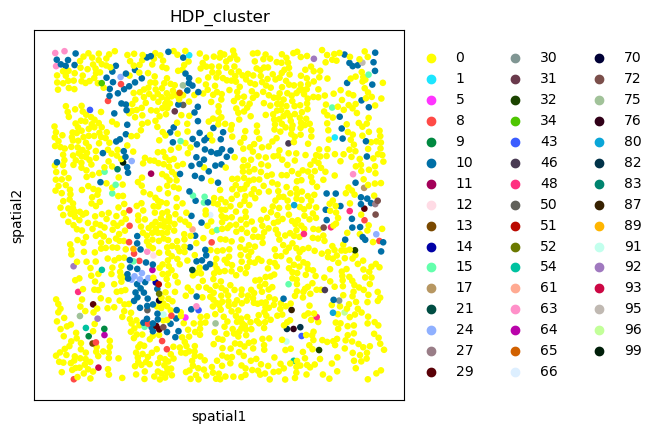

In [62]:
sc.pl.spatial(adata_sub, spot_size=10, color=['HDP_cluster'])

In [63]:
adata_sub_15nn=sc.read_h5ad("/wynton/home/engelhardt/chwu/Projects/HubID/Gensim_revised/objects/adata_G4423_15_neighbor_sub500.h5ad")




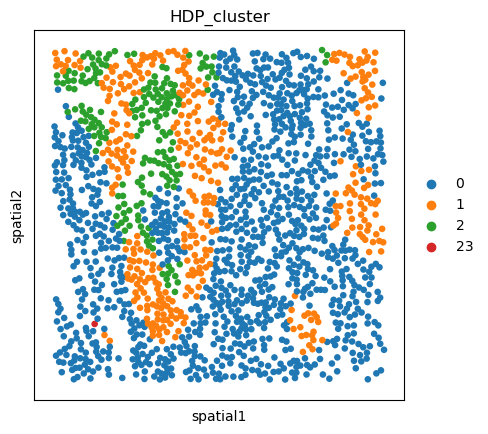

In [64]:
sc.pl.spatial(adata_sub_15nn, spot_size=10, color=['HDP_cluster'])

In [65]:
adata_sub.obs

,index,n_genes,HDP_cluster
106763,106763,22,0
106765,106765,55,0
106767,106767,45,0
106769,106769,17,0
106771,106771,66,0
...,...,...,...
244008,244008,63,0
244011,244011,47,0
244013,244013,53,10
244015,244015,38,0


In [69]:
adata_sub_15nn.obs_names

Index(['106763', '106765', '106767', '106769', '106771', '106773', '106774',
       '106775', '106779', '106780',
       ...
       '244001', '244003', '244004', '244005', '244006', '244008', '244011',
       '244013', '244015', '244018'],
      dtype='object', length=1700)

In [71]:
adata_sub.obs

,index,n_genes,HDP_cluster
106763,106763,22,0
106765,106765,55,0
106767,106767,45,0
106769,106769,17,0
106771,106771,66,0
...,...,...,...
244008,244008,63,0
244011,244011,47,0
244013,244013,53,10
244015,244015,38,0


In [84]:
adata_sub_15nn.obs['keep_in_ori'] = adata_sub_15nn.obs_names.isin((adata_sub.obs_names.tolist()))

In [88]:
adata_sub_15nn.obs['keep_in_ori'].tolist().count(False)

16

In [92]:
adata_sub.obs['HDP_cluster_smoothed']= np.nan

In [97]:
adata_sub.obs['HDP_cluster_smoothed']= adata_sub_15nn[adata_sub.obs_names].obs['HDP_cluster']

In [102]:
adata_sub.write_h5ad(
    "/wynton/home/engelhardt/chwu/Projects/HubID/Gensim_revised/objects/adata_G4423_cbn_sub500.h5ad",
    compression="gzip"
)

In [ ]:
########################

In [ ]:
# try on adata_sub

In [ ]:
# visualize each cluster separately
# pick the corner case
x_minc=min(adata_sub.obsm['spatial'][:,0])
x_maxc=max(adata_sub.obsm['spatial'][:,0])
y_minc=min(adata_sub.obsm['spatial'][:,1])
y_maxc=max(adata_sub.obsm['spatial'][:,1])


In [ ]:
print(x_min)
print(x_max)
print(y_min)
print(y_max)

In [ ]:
x_minc=np.argmin(adata_sub.obsm['spatial'][:,0])
x_maxc=np.argmax(adata_sub.obsm['spatial'][:,0])
y_minc=np.argmin(adata_sub.obsm['spatial'][:,1])
y_maxc=np.argmax(adata_sub.obsm['spatial'][:,1])
#print(adata_sub.obsm['spatial'][x_minc,0])
#print(adata_sub.obsm['spatial'][x_maxc,0])
idx_corners=[x_minc, x_maxc, y_minc, y_maxc]
idx_corners


In [ ]:
adata_sub.obs

In [ ]:
# pwd
# import matplotlib.backends.backend_pdf
# pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")
# for fig in xrange(1, figure().number): ## will open an empty extra figure :(
#     pdf.savefig( fig )
# pdf.close()

In [ ]:
hdp.m_lambda_sum

In [ ]:
prop.sum(1)

In [ ]:
# import pandas as pd
# import matplotlib.backends.backend_pdf

pdf = matplotlib.backends.backend_pdf.PdfPages("./Plots/merFISH_G4423_subregion_15neighbors_topics_no_legend.pdf")
#pplot.figure(figsize=(10,7))
# pplot.subplot(1,2,1)
# sns.countplot('Mode used for Egress',hue='Sex', data=dataframe)
# pplot.subplot(1,2,2)
# sns.countplot('Mode used for Egress',hue='Income per Month (Rs)', data=dataframe)
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10), gridspec_kw={'wspace':0.9})
ax1.set_xlim(0,15000)
ax1.set_ylim(0,15000)
#ax1.set_title("HDP all topics")
sc.pl.spatial(adata_sub, spot_size=10, color=['HDP_cluster'],title="HDP all topics" , show=False, ax=ax1)
pdf.savefig( fig )

for ii in range(100):
    adata_sub_sub=adata_sub[(adata_sub.obs.HDP_cluster == ii) | (adata_sub.obs[0].isin(idx_corners)) ]
    adata_sub_sub.obs['tmp']=str(ii)
    fig, (ax1) = plt.subplots(1, 1, figsize=(10,10), gridspec_kw={'wspace':0.9})
    ax1.set_xlim(0,15000)
    ax1.set_ylim(0,15000)
    #ax1.set_title("HDP_topic"+str(ii))
    sc.pl.spatial(adata_sub_sub, spot_size=10, color='tmp',title="HDP topic "+str(ii), legend_loc=None, show=False, ax=ax1 )#, palette= sns.color_palette("hls", 8) )#, color=['HDP_cluster'])
    pdf.savefig( fig )
pdf.close()   
#pplot.savefig('test.pdf')
    #np.array(clusters)

In [ ]:
adata_sub.obs

In [ ]:
for ii in range(K):
    adata_sub.obs['HDP'+str(ii)]=prop[:,ii]

In [ ]:
minnx=min(np.ndarray.flatten(adata_sub.obsm['spatial']))
maxx=max(np.ndarray.flatten(adata_sub.obsm['spatial']))
print(minn)
print(maxx)
K

In [ ]:
adata_sub_plot=adata_sub

In [ ]:
adata_sub_plot.obsm['spatial']

In [ ]:
## plot continuous activity scores
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

pdf = matplotlib.backends.backend_pdf.PdfPages("./Plots/merFISH_G4423_subregion2_15neighbors_topics_p10_continous_activity_score.pdf")
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10), gridspec_kw={'wspace':0.9})
#ax1.set_xlim(minn,maxx)
#ax1.set_ylim(minn,maxx)
#ax1.set_title("HDP all topics")
sc.pl.spatial(adata_sub_plot, spot_size=10, color=['HDP_cluster'],title="HDP all topics" , show=False, ax=ax1)
pdf.savefig( fig )

for ii in range(K):
    fig, (ax1) = plt.subplots(1, 1, figsize=(10,10), gridspec_kw={'wspace':0.9})
    #ax1.set_xlim(minn,maxx)
    #ax1.set_ylim(minn,maxx)
    #ax1.set_title("HDP_topic"+str(ii))
    sc.pl.spatial(adata_sub_plot, spot_size=10, color=['HDP'+str(ii)], show=False, title="HDP topic "+str(ii),ax=ax1)
    pdf.savefig( fig )
    print(ii)

pdf.close()   




In [ ]:
sc.pl.spatial(adata_sub_plot, spot_size=30, color=['HDP_cluster'],title="HDP all topics" , show=True)

In [ ]:
tmp=adata_sub.copy()

In [ ]:
tmp2.shape

In [ ]:
tmp2=tmp[((tmp.obsm['spatial'][:,0]>2500)& (tmp.obsm['spatial'][:,0]<5000)) & ((tmp.obsm['spatial'][:,1]<max((tmp.obsm['spatial'][:,1]))) & (tmp.obsm['spatial'][:,1]>(max(tmp.obsm['spatial'][:,1])-2500))) ]
                                            
                                            
                                            

In [ ]:
sc.pl.spatial(tmp2, spot_size=10, color=['HDP_cluster'],title="HDP all topics" , show=True)

In [ ]:
import gc
del tmp2
gc.collect()

In [ ]:
import seaborn as sns

sns.color_palette("hls", 8)[0]

In [ ]:
import matplotlib
matplotlib.colors.is_color_like('red')


In [ ]:
adata_sub[ adata_sub.obs[0].isin(idx_corners) ]

In [ ]:
# visulize only sub data

In [ ]:
cluster_counts=[]
for ii in range(100):
    cluster_counts.append(clusters.count(ii))
print(cluster_counts)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


N = 50
x = [*range(100)]
y = cluster_counts
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, s=1)
#plt.ylim(0, 10000)
plt.title("Number of meta-cells assigend to the main clsuter")
plt.show()


In [ ]:
# test on th example visium data
# tmp=sc.datasets.visium_sge()
# tmp.obsm['spatial']
# sc.pl.spatial(tmp, spot_size=100, color='in_tissue')

# get topic information

In [ ]:
topic_info=hdp.get_topics()
df_topic_info=pd.DataFrame(topic_info)
df_topic_info.columns=hdp.id2word.id2token.values()
df_topic_info.to_csv("./Tables/G4420_subregion_topic_info_hdp_seed0.csv")

In [ ]:
top20=pd.DataFrame(hdp.print_topics(100))
top20=top20.iloc[:,1:]
top20.columns=['Top20 genes']
top20.to_csv("./Tables/G4420_subregion_top20_genes_hdp_seed0.csv")
top20